In [47]:
import torch
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torch.optim.lr_scheduler import CosineAnnealingLR
import random
import numpy as np
import os
import torch.nn.utils.prune as prune
import matplotlib.pyplot as plt
import copy
import pickle
from collections import defaultdict

In [48]:
def fix_random_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Fixed random seed: {seed}")

fix_random_seed(42)

# For deterministic DataLoader behavior
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

Fixed random seed: 42


In [49]:
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]
BATCH_SIZE = 128
NUM_WORKERS = 4
VAL_RATIO = 0.05

g = torch.Generator()
g.manual_seed(42)

transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std),
])

def split_train_val(dataset, ratio=VAL_RATIO, generator=g):
    total_size = len(dataset)
    val_size = int(ratio * total_size)
    train_size = total_size - val_size
    return random_split(dataset, [train_size, val_size], generator=generator)

train_dataset = torchvision.datasets.CIFAR100(
    root='./data', train=True, download=True, transform=transform
)

train_dataset, val_dataset = split_train_val(train_dataset, VAL_RATIO, g)

test_dataset = torchvision.datasets.CIFAR100(
    root='./data', train=False, download=True, transform=transform
)

print("Training set size:", len(train_dataset))
print("Validation set size:", len(val_dataset))
print("Test set size:", len(test_dataset))

def get_loader(dataset, shuffle):
    return DataLoader(
        dataset,
        batch_size=BATCH_SIZE,
        shuffle=shuffle,
        num_workers=NUM_WORKERS,
        pin_memory=True,
        worker_init_fn=seed_worker,
        generator=g
    )

train_loader = get_loader(train_dataset, shuffle=True)
val_loader = get_loader(val_dataset, shuffle=False)
test_loader = get_loader(test_dataset, shuffle=False)

Training set size: 47500
Validation set size: 2500
Test set size: 10000


In [50]:
def plot_weight_histograms(model, title):
    # Collect (layer_name, weights) pairs
    layer_weights = []
    for name, module in model.named_modules():
        if isinstance(module, (torch.nn.Conv2d, torch.nn.Linear)):
            layer_weights.append((name, module.weight.detach().cpu().numpy().flatten()))

    # Plot histograms
    plt.figure(figsize=(15, 8))
    for i, (name, w) in enumerate(layer_weights[:11]):  # limit to first 11 for readability
        plt.subplot(5, 6, i + 1)
        plt.hist(w, bins=40, color='blue', alpha=0.7)
        plt.title(name, fontsize=9)  # <-- actual layer name
        plt.tight_layout()
    plt.suptitle(title, y=1.02)
    plt.show()

In [51]:
vgg11 = models.vgg11(weights=models.VGG11_Weights.IMAGENET1K_V1)
vgg11.classifier[6] = torch.nn.Linear(4096, 100)
vgg11.classifier[5] = torch.nn.Dropout(p=0.5) # Dropout
device = "cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu"
vgg11.load_state_dict(torch.load('models/vgg11_cifar100_baseline.pt', weights_only=True, map_location=device))
vgg11.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [52]:
with open('models/sensitivity_dict.pkl', 'rb') as f:
    sensitivity_dict = pickle.load(f)

In [53]:
prune_amts = [0,10,20,30,40,50,60,70,80,90]

desired_prune = 0.7  # 70%
max_layer_prune = 0.9  # don't prune more than 90% of any single layer

# 1) gather layers, param counts and baseline accuracies
layer_param_count = {}
baseline_acc = {}
for name, module in vgg11.named_modules():
    if isinstance(module, (torch.nn.Conv2d, torch.nn.Linear)):
        nparams = sum(p.numel() for p in module.parameters())
        layer_param_count[name] = nparams
        baseline_acc[name] = sensitivity_dict.get((name, 0), None)  # accuracy at 0% prune

total_params = sum(layer_param_count.values())
total_remove_target = int(desired_prune * total_params)

# 2) compute robustness R_l using average-normalized method
R = {}
for name in layer_param_count:
    accs = []
    for p in prune_amts:
        acc = sensitivity_dict.get((name, p))
        if acc is not None:
            accs.append(acc)
    acc0 = baseline_acc.get(name)
    if not accs or acc0 is None or acc0 == 0:
        R[name] = 0.0
    else:
        R[name] = (sum(accs) / len(accs)) / acc0  # ~1 if robust, <1 if sensitive

print("Robustness")
print(R)

# avoid zeros by adding tiny epsilon so every layer gets something
eps = 1e-8
weighted = {name: max(R[name], eps) for name in R}

# 3) allocate removals proportional to weighted * param_count
denom = sum(weighted[n] * layer_param_count[n] for n in weighted)
remove_alloc = {}
for name in weighted:
    remove_alloc[name] = total_remove_target * (weighted[name] * layer_param_count[name]) / denom

# 4) compute per-layer prune percent and clamp
prune_pct = {}
for name in remove_alloc:
    pct = remove_alloc[name] / layer_param_count[name]
    pct = min(max(pct, 0.0), max_layer_prune)
    prune_pct[name] = pct
print()
print("Prune Pct")
print(prune_pct)

Robustness
{'features.0': 0.834952120383037, 'features.3': 0.9886548913043479, 'features.6': 0.9909090909090909, 'features.8': 0.9766689143627781, 'features.11': 0.9795254237288135, 'features.13': 0.9643724696356277, 'features.16': 0.9839346494213752, 'features.18': 0.9775051124744375, 'classifier.0': 0.9998640380693403, 'classifier.3': 1.0038303693570454, 'classifier.6': 0.9894594594594595}

Prune Pct
{'features.0': 0.5852404316529262, 'features.3': 0.692974843967458, 'features.6': 0.6945548731900995, 'features.8': 0.6845735498718776, 'features.11': 0.6865757542301734, 'features.13': 0.675954640542547, 'features.16': 0.6896662992860818, 'features.18': 0.6851596636523786, 'classifier.0': 0.700831636867386, 'classifier.3': 0.7036117453050174, 'classifier.6': 0.6935387874594222}


In [54]:
def prune_layer_unstructured_L2(module, amount=0.3):
    # Only prune Conv2d or Linear layers
    if not isinstance(module, (torch.nn.Conv2d, torch.nn.Linear)):
        return 0

    with torch.no_grad():
        # Flatten weights
        weights = module.weight.data.view(-1)
        num_params = weights.numel()
        num_prune = int(amount * num_params)

        if num_prune == 0:
            return 0

        # Compute L2 magnitudes (since weights are scalars, this is just abs)
        magnitudes = weights.abs()

        # Get threshold
        threshold = torch.topk(magnitudes, num_prune, largest=False).values.max()

        # Zero out the smallest weights
        mask = magnitudes > threshold
        module.weight.data.view(-1)[~mask] = 0

        return num_prune

In [55]:
# 5) apply pruning (use a copy of the model)
vgg_pruned = copy.deepcopy(vgg11)

for name, module in vgg_pruned.named_modules():
    if name in prune_pct:
        p = prune_pct[name]
        if p <= 0:
            continue
        if isinstance(module, (torch.nn.Conv2d, torch.nn.Linear)):
            try:
                prune_layer_unstructured_L2(module)
            except Exception as e:
                print(f"Cannot prune layer {name}: {e}")

# 6) Optional: remove reparameterization to finalize model
for name, module in vgg_pruned.named_modules():
    if isinstance(module, (torch.nn.Conv2d, torch.nn.Linear)):
        try:
            prune.remove(module, 'weight')
        except Exception:
            pass


In [56]:
# Print per-layer pruning summary
print(f"{'Layer':<35} {'Type':<15} {'Total Params':>15} {'Pruned %':>10} {'Pruned Params':>15}")
print("=" * 95)

total_params_before = sum(layer_param_count.values())
total_pruned_params = 0

for name, module in vgg_pruned.named_modules():
    if name in prune_pct and isinstance(module, (torch.nn.Conv2d, torch.nn.Linear)):
        total = layer_param_count[name]
        pct = prune_pct[name]
        pruned = int(total * pct)
        total_pruned_params += pruned
        print(f"{name:<35} {type(module).__name__:<15} {total:>15,} {pct*100:>9.1f}% {pruned:>15,}")

print("=" * 95)
print(f"{'Total model parameters before pruning:':<60} {total_params_before:,}")
print(f"{'Total parameters pruned:':<60} {total_pruned_params:,}")
print(f"{'Remaining parameters after pruning:':<60} {total_params_before - total_pruned_params:,}")
print(f"{'Overall prune percentage:':<60} {(total_pruned_params / total_params_before) * 100:.2f}%")


Layer                               Type               Total Params   Pruned %   Pruned Params
features.0                          Conv2d                    1,792      58.5%           1,048
features.3                          Conv2d                   73,856      69.3%          51,180
features.6                          Conv2d                  295,168      69.5%         205,010
features.8                          Conv2d                  590,080      68.5%         403,953
features.11                         Conv2d                1,180,160      68.7%         810,269
features.13                         Conv2d                2,359,808      67.6%       1,595,123
features.16                         Conv2d                2,359,808      69.0%       1,627,480
features.18                         Conv2d                2,359,808      68.5%       1,616,845
classifier.0                        Linear              102,764,544      70.1%      72,020,643
classifier.3                        Linear        

In [57]:
torch.save(vgg_pruned.state_dict(), "models/vgg11_cifar100_pruned_unstructured.pt")

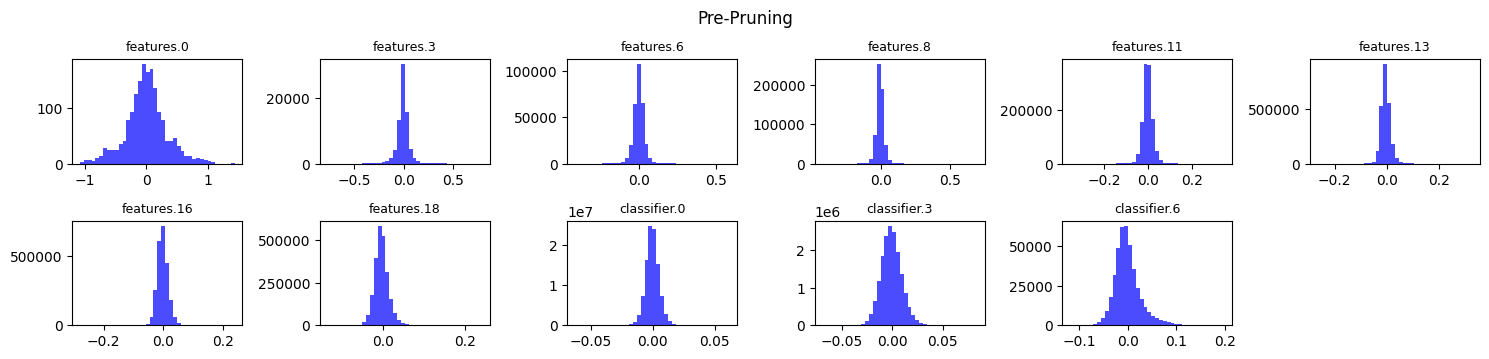

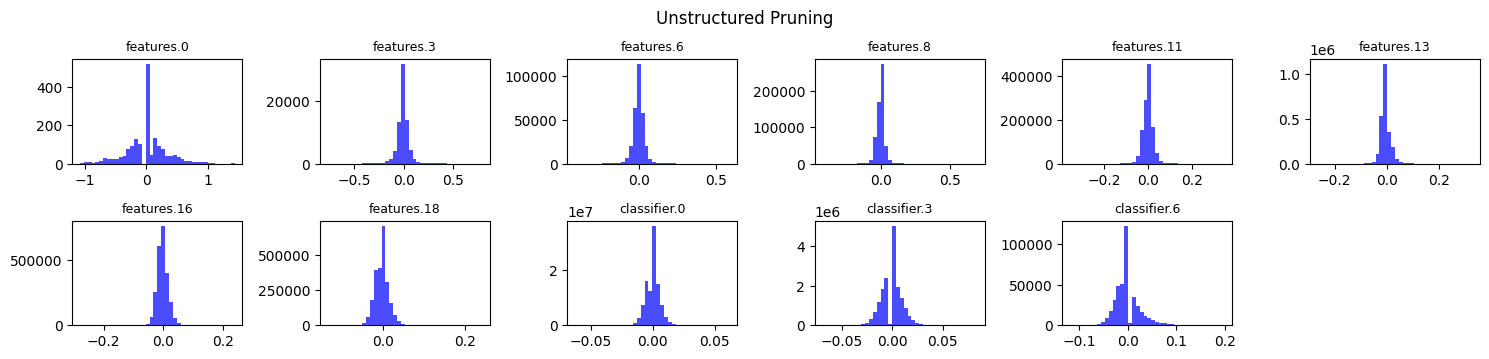

In [58]:
plot_weight_histograms(vgg11, "Pre-Pruning")
plot_weight_histograms(vgg_pruned, "Unstructured Pruning")

In [59]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.to(device)
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    avg_loss = running_loss / total
    accuracy = 100. * correct / total
    return avg_loss, accuracy

In [60]:
def evaluate(model, test_loader, device):
    model.to(device)
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            preds = model(images)
            preds = torch.argmax(preds, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    accuracy = correct / total * 100
    return accuracy

In [61]:
acc = evaluate(vgg_pruned, test_loader, device)
print(f"Post-Pruning no finetuning accuracy: {acc:.2f}%")

Post-Pruning no finetuning accuracy: 72.03%


In [62]:
print("Finetuning...")
base_lr = 0.04
weight_decay = 5e-4
num_epochs = 5
optim = torch.optim.SGD(
    vgg_pruned.parameters(),
    lr=base_lr,
    momentum=0.9,
    weight_decay=weight_decay
)

scheduler = CosineAnnealingLR(optim, T_max=num_epochs, eta_min=1e-5)

criterion = torch.nn.CrossEntropyLoss()

Finetuning...


In [63]:
best_val = 0
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(vgg_pruned, train_loader, criterion, optim, device)
    scheduler.step()
    val_acc = evaluate(vgg_pruned, val_loader, device)
    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}")
    if val_acc > best_val:
      best_val = val_acc
      torch.save(vgg_pruned.state_dict(), "models/vgg11_cifar100_pruned_unstructured_finetuned.pt")

Epoch 1/5 | Loss: 1.3435 | Train Acc: 61.91% | Val Acc: 55.96
Epoch 2/5 | Loss: 1.2118 | Train Acc: 65.52% | Val Acc: 59.28
Epoch 3/5 | Loss: 0.8457 | Train Acc: 75.08% | Val Acc: 64.40
Epoch 4/5 | Loss: 0.4930 | Train Acc: 84.89% | Val Acc: 71.20
Epoch 5/5 | Loss: 0.2602 | Train Acc: 91.86% | Val Acc: 72.84


In [64]:
acc = evaluate(vgg_pruned, test_loader, device)
print(f"Post-Pruning Finetuned Accuracy: {acc:.2f}%")

Post-Pruning Finetuned Accuracy: 72.76%


In [65]:
def print_zero_weights(model):
    print("\n=== Zero Weights per Layer ===")
    for name, module in model.named_modules():
        if isinstance(module, (torch.nn.Conv2d, torch.nn.Linear)):
            weights = module.weight.detach().cpu()
            zero_count = (weights == 0).sum().item()
            total = weights.numel()
            print(f"{name:<20} {zero_count:>10} / {total:<10} ({100*zero_count/total:6.2f}%)")
print_zero_weights(vgg11)



=== Zero Weights per Layer ===
features.0                    0 / 1728       (  0.00%)
features.3                    0 / 73728      (  0.00%)
features.6                    0 / 294912     (  0.00%)
features.8                    0 / 589824     (  0.00%)
features.11                   0 / 1179648    (  0.00%)
features.13                   0 / 2359296    (  0.00%)
features.16                   0 / 2359296    (  0.00%)
features.18                   0 / 2359296    (  0.00%)
classifier.0                  0 / 102760448  (  0.00%)
classifier.3                  0 / 16777216   (  0.00%)
classifier.6                  0 / 409600     (  0.00%)
